In [1]:
import seir_module.seir_module as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Модель SEIR для предсказания распространения COVID-19

SEIR - модель из семейства полигамных моделей, описывающих распространение эпидемии.

${\frac {dS}{dt}}=\mu N-\mu S-\beta {\frac {I}{N}}S$  
${\frac {dE}{dt}}=\beta {\frac {I}{N}}S-(\mu +a)E$  
${\frac {dI}{dt}}=aE-(\gamma +\mu )I$  
${\frac {dR}{dt}}=\gamma I-\mu R$

$S(t)$ - (Susceptible) количество людей, подверженных заражению.  
$E(t)$ - (Exposed) количество носителей, т.е. заражённых людей, у которых болезнь еще не проявилась из-за инкубационного периода.   
$I(t)$ - (Infectious) - инфецированные.  
$R(t)$ - (Recovered) - выздоровевшие.  
$N = S + E + I + R$ - численность популяции. Она сохраняется постоянной, т.е. предполагается, что от болезни никто не умирает.  
$\mu$ - уровень естественной смертности.  
$\alpha$ - величина, обратная инкубационному периоду заболевания.  
$\gamma$ - величина, обратная среднему времени выздоровления.  
$\beta$ - коэффициент интенсивности контактов, приводящих к заражению.  

Жизненный цикл индивида в SEIR:

<img src="files/SEIR.PNG">

* Здоровый, но ещё не переболевший человек (Susceptible) может заразиться от инфицированного (Infectious) человека. Вероятность, с которой здоровый человек заразится описывается параметром $\beta$.
* Заразившийся человек переходит в состояние носителя инфекции (Exposed). Носители - это люди, у которых заболевание ещё не проявилось, т.е. у них протекает инкубационный период. Носители не могут никого заразить. Переход подверженных заболеванию людей в состояние носителей описывается двумя первыми уравнениями модели (посредством слагаемого $\beta {\frac {I}{N}}S$)
* Через $1/\alpha$ дней (инкубационный период) после заражения носитель переходит в состояние инфицированного (Infectious). 
* Через $1/\gamma$ дней (время выздоровления), инфицированный переходит в состояние выздоровевшего (Recovered). У выздоровевшего человека вырабатывается иммунитет и он больше не может заразиться этой инфекцией.
* Также, модель предусматривает естественную смертность населения в популяции. Смертность в SEIR модели сбалансирована рождаемостью, поэтому общая численность населения не меняется. Выздоровевшие люди рано или поздно умрут и заместятся новорожденными, которые иммунитет уже иметь не будут. Поэтому со временем количество выздоровевших людей в популяции уменьшается. Интенсивность смертности описывается параметром $\mu$.  
Типичное решение SEIR модели выглядит так:

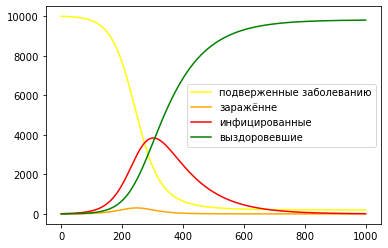

In [2]:
S, E, I, R = sm.solve_seir(S0=10_000, E0=5, I0=10, R0=0,
                        betas=[0.04]*100000, gamma=0.01, alpha=sm.alpha, mu=0, times=np.arange(0, 1000,1))
plt.plot(S, color='yellow', label='подверженные заболеванию')
plt.plot(E, color='orange', label='заражённе')
plt.plot(I, color='red', label='инфицированные')
plt.plot(R, color='green', label='выздоровевшие')
plt.legend()

### Решение модели
Ну вот, уравнение модели есть, осталось его решить. Для этого нужны начальные условия для всех четырёх функций, а также неизвестные коэффициенты.  
Сделаем первое упрощение модели - т.к. мы рассматриваем развитие эпидемии на достаточно коротком промежутке времени, то будем считать, что естественная смертность населения равна нулю, т.е. $\mu = 0$.  
Также известно, что инкубационный период COVID-19 равен 5.1 день. 
Теперь, все остальные параметры для каждой страны и региона мы можем подобрать по имеющимся данным. После зануления коэффициента смертности $\mu$ и замены операторов дифференцирования на операторы конечной разности, имеем:  

${\Delta S}=-\beta {\frac {I}{N}}S$  
${\Delta E}=\beta {\frac {I}{N}}S-aE$  
${\Delta I}=aE-\gamma I$  
${\Delta R}=\gamma I$  

В качестве оператора конечной разности $\Delta$ в этом решении использована двухсторонняя разность.  
Количество выздоровевших людей $R$ по дням есть в исходных данных, а количество инфицированных $I$ равно количеству подтвержденных случаев минус количество выздоровевших. Так что из последнего уравнения можем найти $\gamma$ с помощью оптимизации целевой функции $\text{MALE}(\Delta R-\gamma I)$. Теперь, из третьего уравнения можно найти $E$, а затем и $S$, т.к. $S=N-I-E-R$ (т.е. заболеванию в любой момент времени подвержено всё населения, кроме тех, кто уже заразился и выздоровел).  

Для того, чтобы проследить, как карантинные мероприятия влияют на развитие эпидемии, немного усложним себе задачу и заменим коэффициент $\beta$ на функцию $\beta(t)$ - ведь по мере того, как в стране вводится карантин, интенсивность заражений должна падать, а значит в нашем случае $\beta$ не будет константой. Т.к. у нас уже есть все начальные условия для решения дифура, вопользуемся оптимизацией для поиска функции $\beta(t)$.

## Запускаем модель

In [3]:
rus_directory='../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/'
country_directory='../COVID-19/csse_covid_19_data/csse_covid_19_time_series/'

In [4]:
rus_regions = pd.read_csv('russia_regions.csv')
countries = pd.read_csv('countries.csv')

Чтобы проиллюстрировать работу модели SEIR на реальных данных, запустим подбор параметров на нескольких примерах. Функцию $\beta(t)$ сначала будем подбирать в виде ступенчатой - с двумя ступеньками. Посмотрим на примере Москвы, а также Италии и Германии.
### Москва

In [21]:
def get_last_N_days(df, N):
    df['date'] = df.index
    cutted_df = (
        df
        .sort_values('date', ascending=False)
        .head(N)
        .sort_values('date', ascending=True)
        .drop(columns=['date'])
    )
    
    return cutted_df

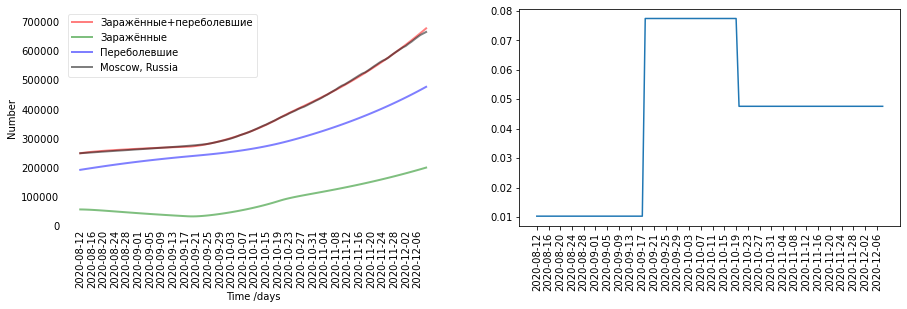

In [23]:
moscow_data = sm.read_data_for_country('Russia', 'Moscow', directory=rus_directory)
moscow_data = get_last_N_days(moscow_data, 120)
result = sm.run_train_test(moscow_data, 'Moscow, Russia', 
                           N=rus_regions[rus_regions.csse_province_state=='Moscow']['population'].iloc[0], 
                           beta_opt_func=sm.optimize_twostep_beta)

In [29]:
moscow_data.index.max()

Timestamp('2020-12-09 00:00:00')

### Италия

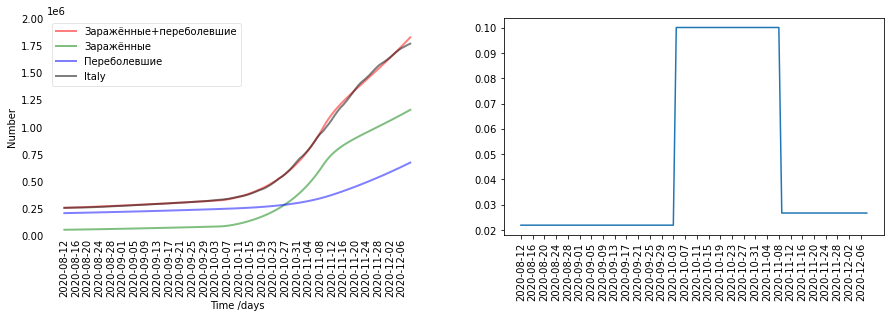

In [24]:
italy_data = sm.read_timeseries_for_country('Italy', directory=country_directory)
italy_data = get_last_N_days(italy_data, N=120)
italy_result = sm.run_train_test(italy_data, 'Italy', 
                           N=countries[countries.ccse_name=='Italy']['population'].iloc[0], 
                           beta_opt_func=sm.optimize_twostep_beta)

### Германия

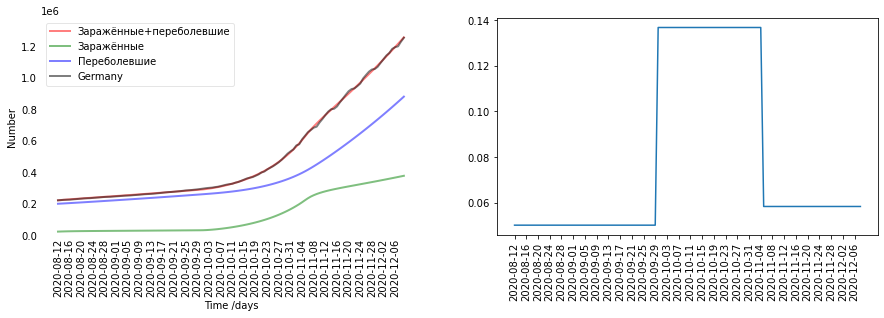

In [25]:
germany_data = sm.read_timeseries_for_country('Germany', directory=country_directory)
germany_data = get_last_N_days(germany_data, N=120)
result = sm.run_train_test(germany_data, 'Germany', 
                           N=countries[countries.ccse_name=='Germany']['population'].iloc[0], 
                           beta_opt_func=sm.optimize_twostep_beta)